# Monte Carlo Simulation of Redcare Pharmacy Stock prices
## Data Acquisition and Preprocessing
* I first load the neccessary python packages `numpy matplotlib seaborn pandas yfinance datetime`

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import os
import ta

* Secondly, I write functions that fetch the Redcare pharmacy stock data **RDC.DE** and at the same time save the raw data under `data/raw/`

In [149]:
def fetch_stock_data(ticker, start_date, end_date, output_dir="."):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    data.to_csv(f"{output_dir}/{ticker}_data_{start_date}_{end_date}.csv", header=True, index=True)
    return data

data = fetch_stock_data("BTC-EUR", "2020-01-01", "2024-12-31", output_dir="../data/raw")

In [103]:
def calculate_log_returns(data):
    """Calculate log returns of the closing prices."""
    data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    return data
data = calculate_log_returns(data)

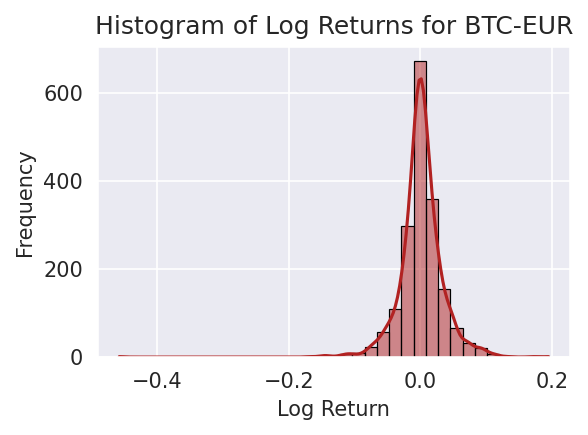

In [109]:
def plot_log_return_histogram(data: pd.DataFrame,ticker: str, output_dir: str | None = None):
    """Plot histogram of log returns."""
    plt.figure(dpi=150, figsize=(4, 3), tight_layout=True)
    sns.set_style('darkgrid')
    sns.histplot(x=data['Log Return'], bins=35, kde=True, color='firebrick', stat='count', edgecolor='black', )
    plt.title(f'Histogram of Log Returns for {ticker}')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'{ticker}_log_return_histogram.png'))
    plt.show()
plot_log_return_histogram(data, ticker="BTC-EUR")

In [110]:
def compute_statistics(data: pd.DataFrame, output_dir: str | None = None) -> pd.DataFrame:
    """Compute basic statistics of log returns."""
    daily_mean = data['Log Return'].mean()
    daily_volatility = data['Log Return'].std()
    annualized_return = daily_mean * 252
    annualized_volatility = daily_volatility * np.sqrt(252)
    stats_df = pd.DataFrame({
        'Daily Mean': [daily_mean],
        'Annualized Return': [annualized_return],
        'Daily Volatility': [daily_volatility],
        'Annualized Volatility': [annualized_volatility]
    })
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        stats_df.to_csv(os.path.join(output_dir, 'RDC_DE_log_return_statistics.csv'), index=False, header=True)
    return stats_df
stats = compute_statistics(data, output_dir="../results/tables")
print(stats)

   Daily Mean  Annualized Return  Daily Volatility  Annualized Volatility
0    0.001441           0.363144          0.033723               0.535328


In [146]:
def _stationary_bootstrap_indices(n: int, p: float, rng: np.random.Generator) -> np.ndarray:
    indices = np.zeros(n, dtype=int)
    current_idx = rng.integers(0, n)
    
    for i in range(n):
        if rng.random() < p:
            current_idx = rng.integers(0, n)
        else:
            current_idx = (current_idx + 1) % n
        indices[i] = current_idx
    return indices

def _decompose_data(
    ohlc: pd.DataFrame, 
    start_index: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df = ohlc.copy()
    df.columns = df.columns.str.lower()
    
    log_bars = np.log(df[['open', 'high', 'low', 'close']])
    
    r_o = (log_bars['open'] - log_bars['close'].shift()).to_numpy()
    
    r_h = (log_bars['high'] - log_bars['open']).to_numpy()
    r_l = (log_bars['low'] - log_bars['open']).to_numpy()
    r_c = (log_bars['close'] - log_bars['open']).to_numpy()

    perm_index = start_index + 1
    
    history_arr = log_bars.iloc[:perm_index].to_numpy()
    
    pool_o = r_o[perm_index:]
    pool_h = r_h[perm_index:]
    pool_l = r_l[perm_index:]
    pool_c = r_c[perm_index:]
    
    return history_arr, pool_o, pool_h, pool_l, pool_c

def _reconstruct_data(
    history_arr: np.ndarray,
    shuffled_o: np.ndarray,
    shuffled_h: np.ndarray,
    shuffled_l: np.ndarray,
    shuffled_c: np.ndarray,
    n_total: int
) -> np.ndarray:
    output = np.zeros((n_total, 4))
    perm_index = len(history_arr)
    
    output[:perm_index] = history_arr
    
    for i in range(perm_index, n_total):
        k = i - perm_index
        
        output[i, 0] = output[i - 1, 3] + shuffled_o[k]
        output[i, 1] = output[i, 0] + shuffled_h[k]
        output[i, 2] = output[i, 0] + shuffled_l[k]
        output[i, 3] = output[i, 0] + shuffled_c[k]
        
    return np.exp(output)

def get_permutation(
    ohlc: pd.DataFrame, 
    probability: float = 0.1, 
    start_index: int = 0, 
    seed=None
) -> pd.DataFrame:
    assert start_index >= 0
    rng = np.random.default_rng(seed)

    history, pool_o, pool_h, pool_l, pool_c = _decompose_data(ohlc, start_index)
    
    perm_n = len(pool_o)
    
    idx_intraday = _stationary_bootstrap_indices(perm_n, probability, rng)
    shuffled_h = pool_h[idx_intraday]
    shuffled_l = pool_l[idx_intraday]
    shuffled_c = pool_c[idx_intraday]

    idx_gap = _stationary_bootstrap_indices(perm_n, probability, rng)
    shuffled_o = pool_o[idx_gap]

    final_data = _reconstruct_data(
        history, 
        shuffled_o, 
        shuffled_h, 
        shuffled_l, 
        shuffled_c, 
        len(ohlc)
    )

    return pd.DataFrame(
        final_data, 
        index=ohlc.index, 
        columns=['Open', 'High', 'Low', 'Close']
    )
    

In [158]:
test_data = data.loc["2020-01-01":"2023-12-31"]

perm_data = get_permutation(test_data)

count    1460.000000
mean        0.001830
std         0.034424
min        -0.367353
25%        -0.012794
50%         0.000697
75%         0.016371
max         0.215004
Name: Close, dtype: float64
count    1460.000000
mean        0.000964
std         0.034261
min        -0.367424
25%        -0.012983
50%         0.000622
75%         0.016045
max         0.213251
Name: Close, dtype: float64
